# How important are the different features for model performance?

In [88]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'mlp_features'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines/train'
bs_merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']
file_names = ['metrics.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [90]:
baseline_df

,baseline,name,value,cv_split,epoch,set,strategy
0,onehot_mlp_graph_2,loss,3.050371,0,0,None,None
1,onehot_mlp_graph_2,mean_absolute_error,7.843695,0,0,train,greedy
2,onehot_mlp_graph_2,accuracy,0.024625,0,0,train,greedy
3,onehot_mlp_graph_2,mean_absolute_error,7.878100,0,0,train,sampling
4,onehot_mlp_graph_2,accuracy,0.048376,0,0,train,sampling
...,...,...,...,...,...,...,...
17995,onehot_mlp_graph,accuracy,0.346140,19,990,train,sampling
17996,onehot_mlp_graph,mean_absolute_error,2.747573,19,990,test,greedy
17997,onehot_mlp_graph,accuracy,0.538835,19,990,test,greedy
17998,onehot_mlp_graph,mean_absolute_error,3.834951,19,990,test,sampling


In [91]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    if metrics_df[l].dtype == bool:
        metrics_df.loc[metrics_df[l], 'label'] += (bw + l)
    else:
        metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

metrics_df['label_inv'] = ''
bw = ''
for l in labels:
    if metrics_df[l].dtype == bool:
        metrics_df.loc[~metrics_df[l], 'label_inv'] += (bw + l)
    bw = ' '


metrics_df['label_bool'] = ''
bw = ''
for l in labels:
    if metrics_df[l].dtype == bool:
        metrics_df.loc[metrics_df[l], 'label_bool'] += (bw + l)
    bw = ' '



# metrics_df['false_label'] = ''
# bw = ''
# for l in labels:
#     metrics_df.loc[~metrics_df[l], 'false_label'] += ' | ' +  l
#     bw = ' '


# metrics_df['true_label'] = ''
# bw = ''
# for l in labels:
#     metrics_df.loc[metrics_df[l], 'true_label'] += ' | ' +  l
#     bw = ' '



to_string = ['layers', 'hidden_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    # synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    # confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['prev_contributions', 'strategy', 'prev_valid', 'round_number', 'prev_common_good', 'prev_punishments']


In [92]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990) & 
    (baseline_df['strategy'] == 'greedy') & 
    (baseline_df['baseline'] == 'onehot_mlp_graph_3') 
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline            name               
onehot_mlp_graph_3  accuracy               0.445015
                    mean_absolute_error    3.030357
Name: value, dtype: float64

## Overview

In [93]:
# metric_name = 'accuracy'

# w1 = (
#     (metrics_df['set'] == 'test') & 
#     (metrics_df['strategy'] == 'greedy') & 
#     (metrics_df['epoch'] == 990)
# )

# w2 = (metrics_df['name'] == metric_name)
# df = metrics_df[w1 & w2]



# df = df.sort_values(labels)
# sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

# for idx, dfg in baseline.groupby(level=0):
#     plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
#     plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

In [94]:
metrics_df['n_features'] = metrics_df[['prev_contributions',
 'prev_valid',
 'round_number',
 'prev_common_good',
 'prev_punishments']].astype(int).sum(1)

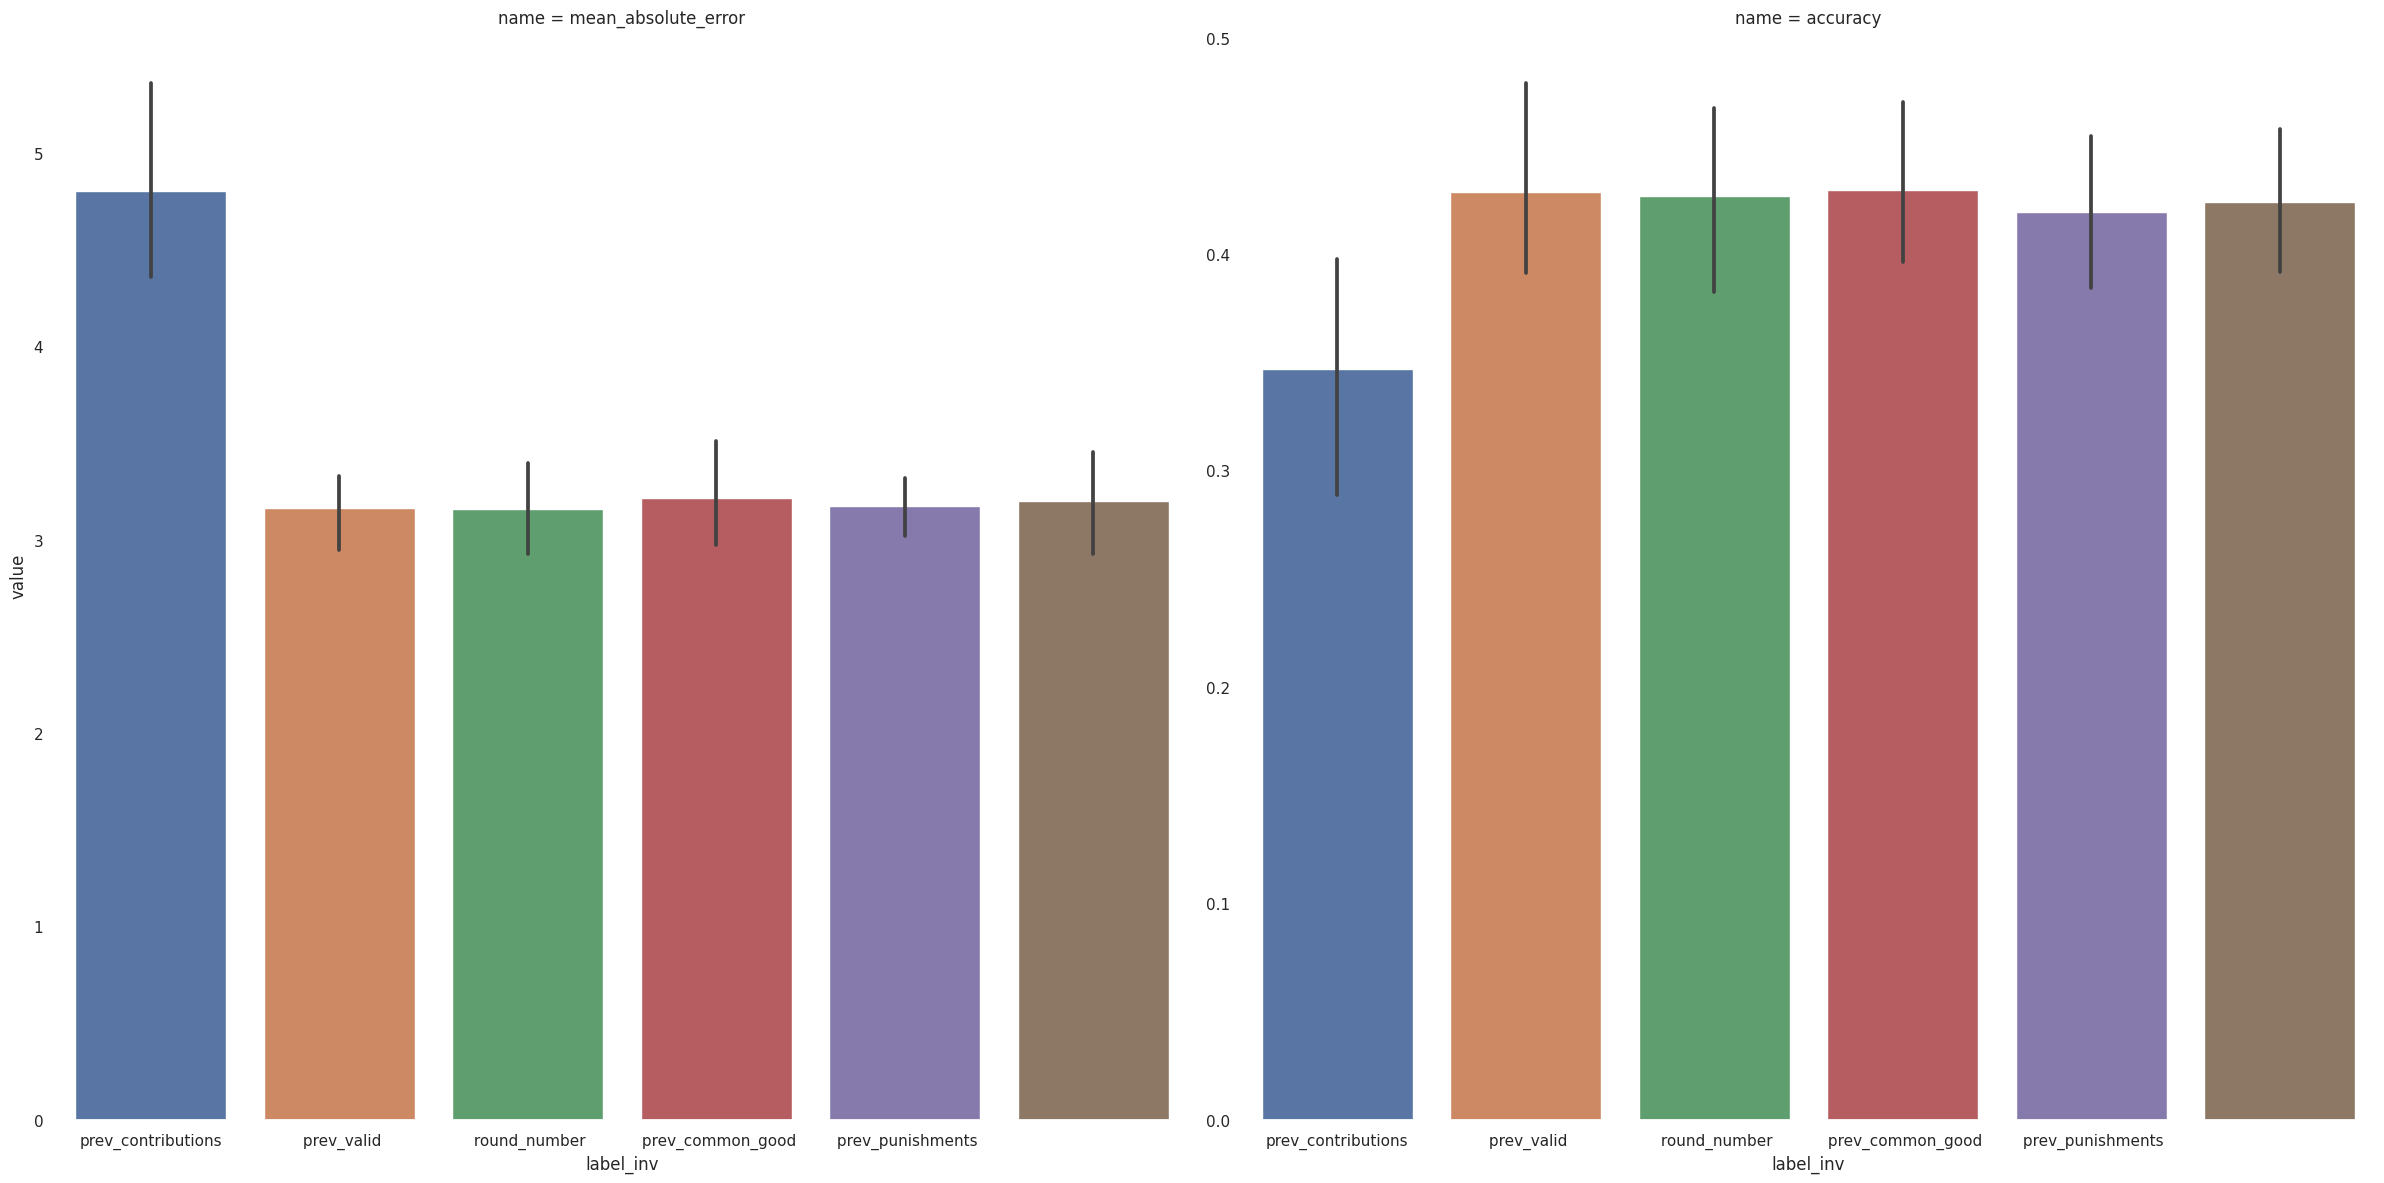

In [95]:
# metric_name = 'accuracy'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['epoch'] == metrics_df['epoch'].max()) 
)

w2 = (metrics_df['name'].isin(['accuracy', 'mean_absolute_error']))


w3 = (metrics_df['n_features'] >= 4)
df = metrics_df[w1 & w2 & w3]

dfref = metrics_df[w1 & w2 & (metrics_df['n_features'] == 5)]

df = df.sort_values(labels)
sns.catplot(data=df, y='value', x='label_inv', orient='v', kind='bar', col='name', sharey=False, height=12)

# plt.axvline(dfref['value'].mean(), color='black', ls='--')
# plt.text('all', 0.5, rotation=90, size=16, va='center')

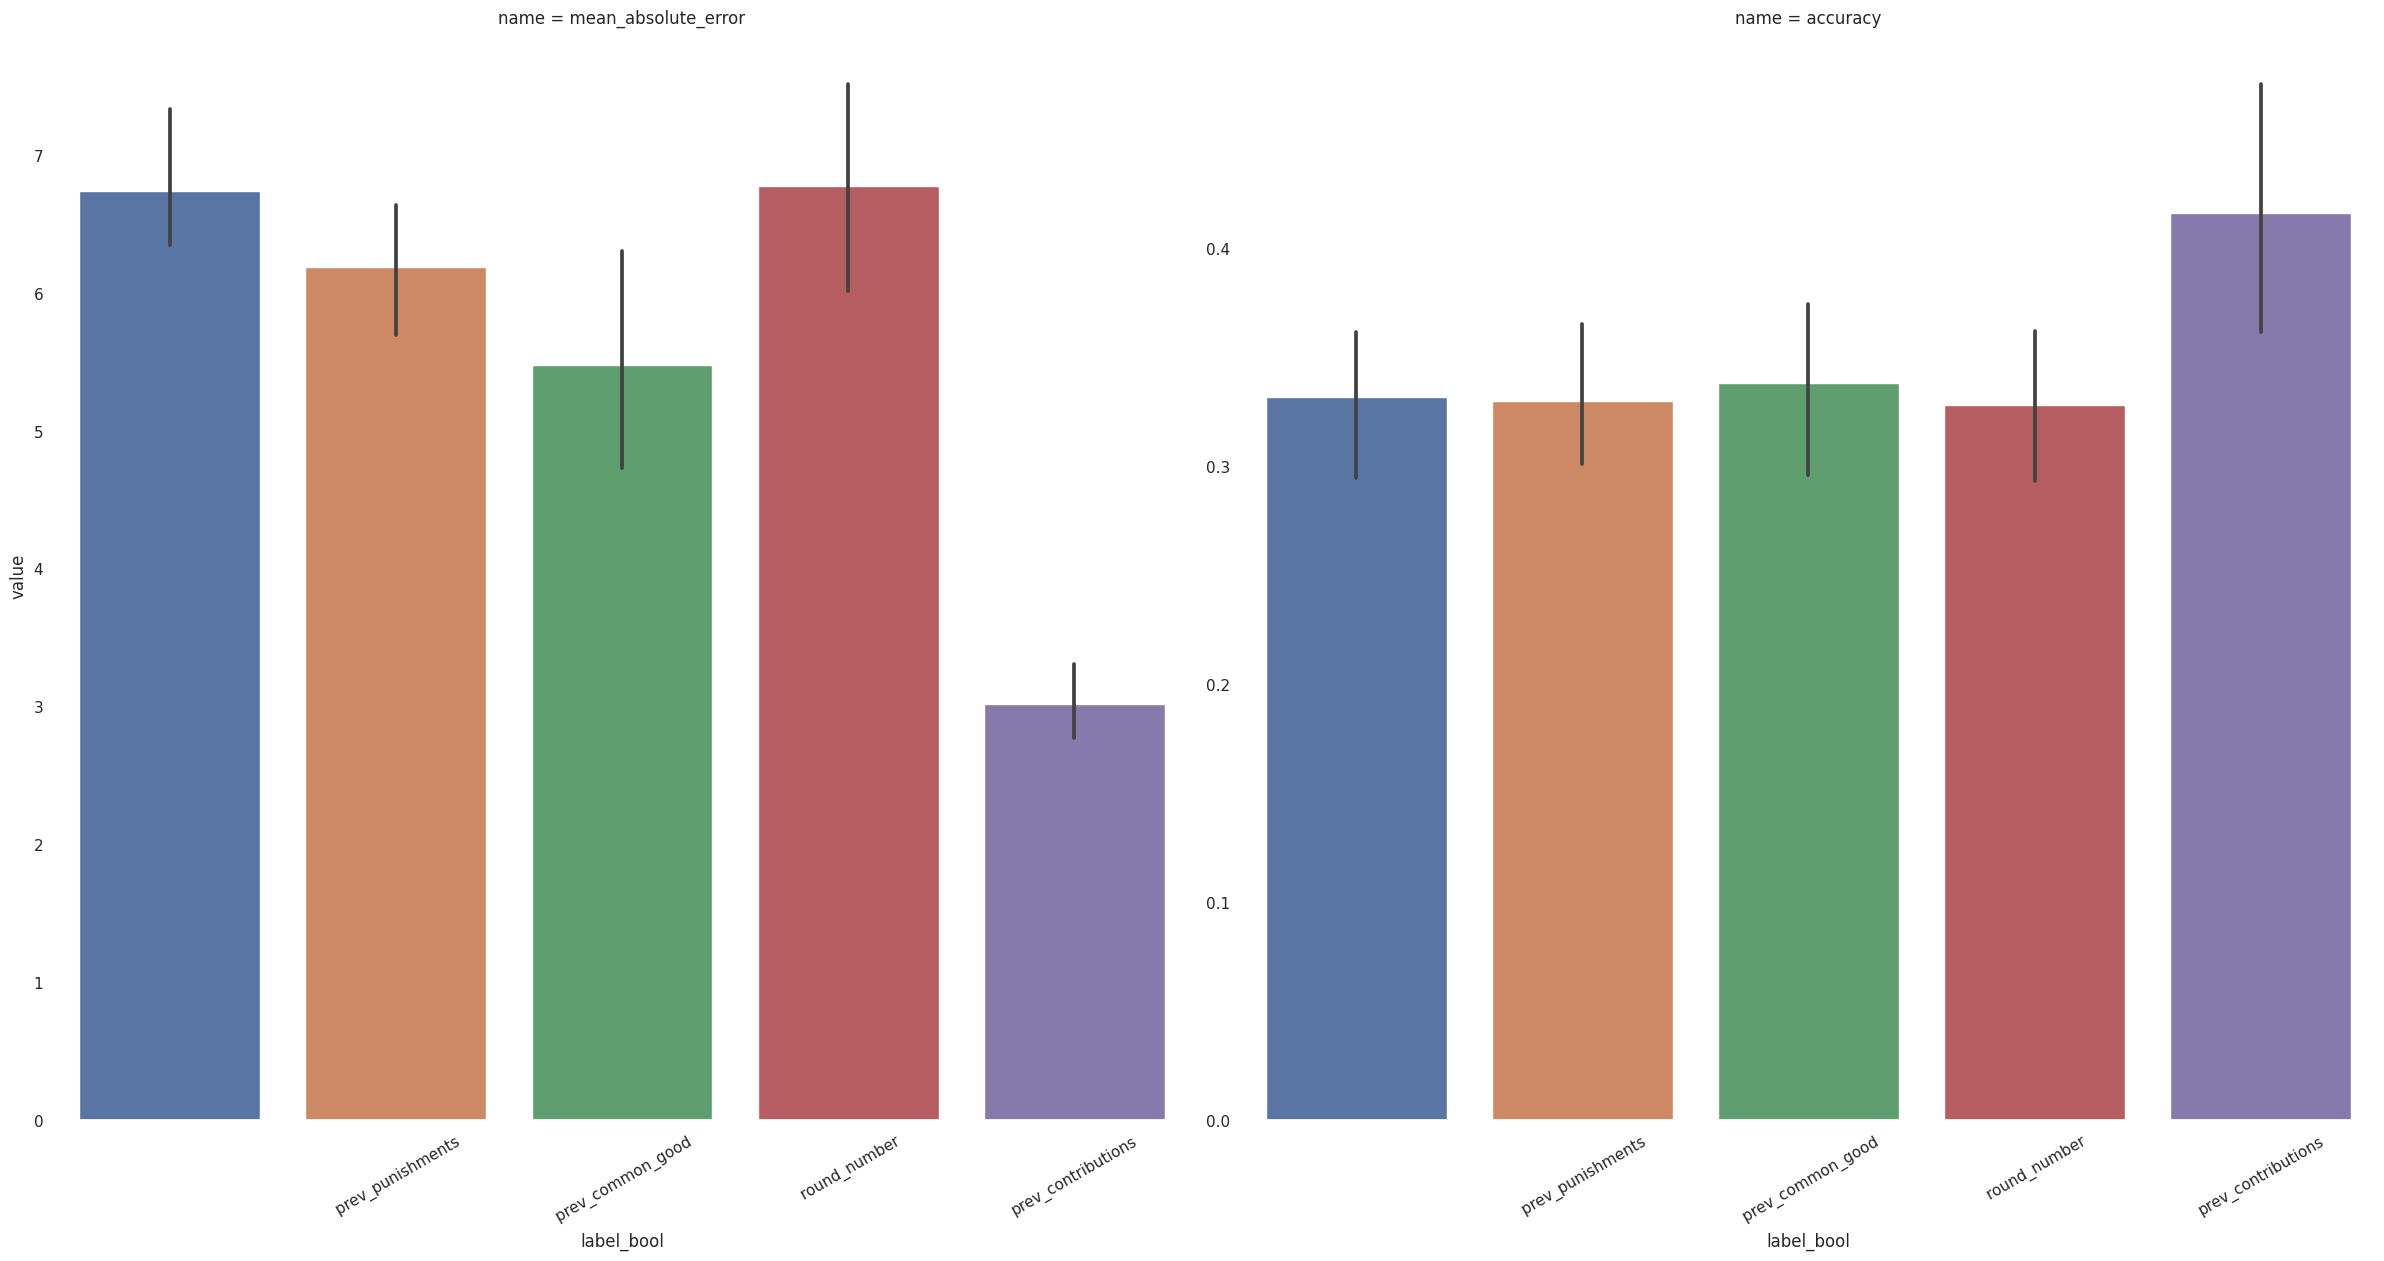

In [120]:
# metric_name = 'accuracy'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['epoch'] == metrics_df['epoch'].max()) &
    #  (metrics_df['prev_contributions'])&
     (~metrics_df['prev_valid'])
)

w2 = (metrics_df['name'].isin(['accuracy', 'mean_absolute_error']))


w3 = (metrics_df['n_features'] <= 1)
df = metrics_df[w1 & w2 & w3]

df = df.sort_values(labels)
g = sns.catplot(data=df, y='value', x='label_bool', orient='v', kind='bar', col='name', sharey=False, height=12)
g.set_xticklabels(rotation=30)

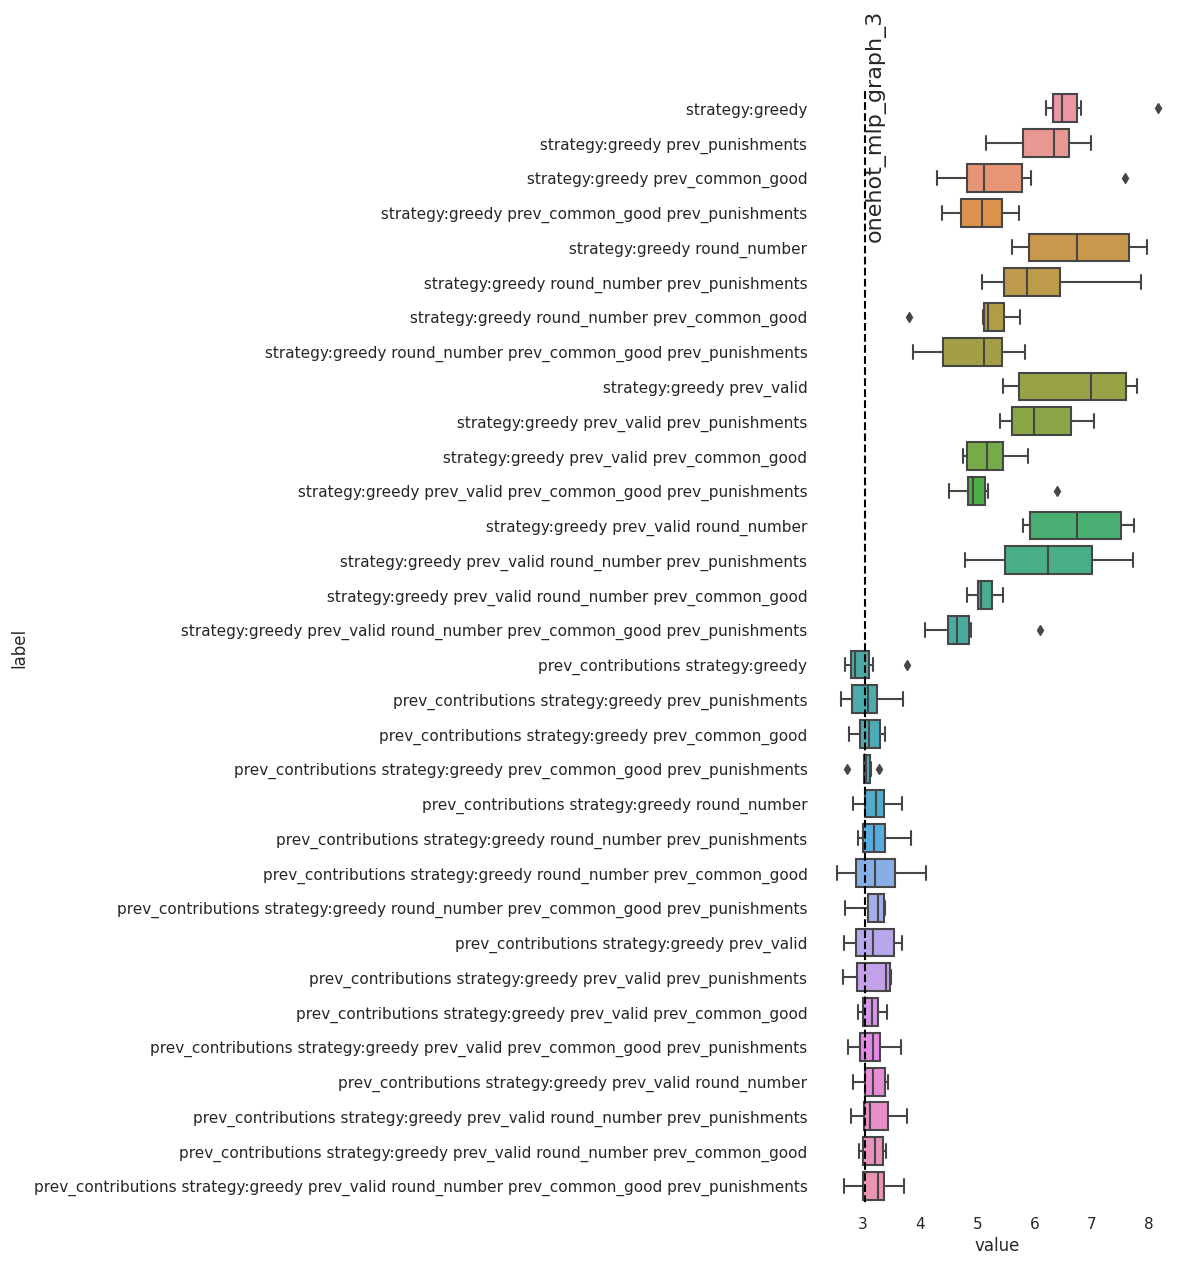

In [97]:
metric_name = 'mean_absolute_error'
w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(labels)
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [98]:
label_ref = {
    # 'fraction_training': 1,
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [99]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

# results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.80].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.328776,0.009318,35.285713,9.726798e-273,0.310514,0.347038
prev_contributions[T.True],0.087086,0.007608,11.447007,2.434056e-30,0.072175,0.101997
prev_punishments[T.True],0.004385,0.007608,0.576331,5.643914e-01,-0.010526,0.019295
prev_valid[T.True],0.003819,0.007608,0.502001,6.156667e-01,-0.011092,0.018730
prev_common_good[T.True],0.003323,0.007608,0.436754,6.622896e-01,-0.011588,0.018234
round_number[T.True],0.002714,0.007608,0.356712,7.213078e-01,-0.012197,0.017625


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [100]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

# results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.50].sort_values('Coef.')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
prev_contributions[T.True],-2.619511,0.099333,-26.370970,2.950608e-153,-2.814201,-2.424822
prev_common_good[T.True],-0.683318,0.099333,-6.879051,6.025268e-12,-0.878007,-0.488628
prev_punishments[T.True],-0.201964,0.099333,-2.033203,4.203201e-02,-0.396654,-0.007275
Intercept,6.226394,0.121658,51.179586,0.000000e+00,5.987949,6.464839


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [101]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is prev_contributions strategy:greedy.
                      name    set     value
12899             accuracy   test  0.397843
12999  mean_absolute_error   test  2.858241
19299             accuracy  train  0.415572
19399  mean_absolute_error  train  3.021528
Best performance for metric accuracy is prev_contributions strategy:greedy prev_valid prev_common_good prev_punishments.
                      name    set     value
17899             accuracy   test  0.446690
17999  mean_absolute_error   test  3.180496
24299             accuracy  train  0.436017
24399  mean_absolute_error  train  3.067196


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

prev_contributions=True|strategy=greedy|prev_valid=True|round_number=False|epoch=990|set=test


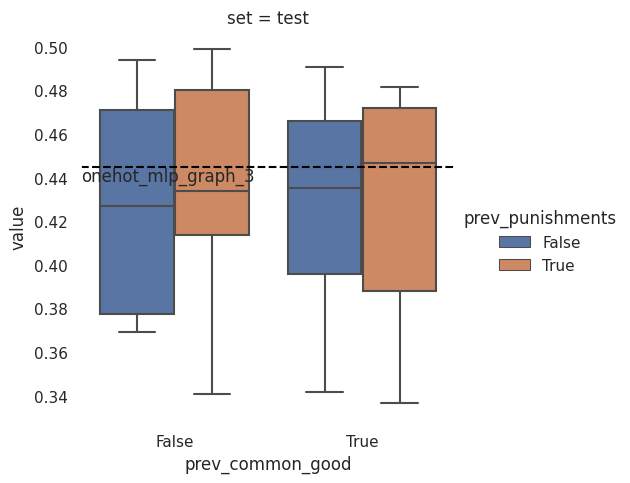

In [102]:
selection = best_labels['accuracy'].copy()

focus = ['prev_common_good', 'prev_punishments']
metric_name = 'accuracy'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990
selection['set'] = 'test'

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

In [103]:
metric_name = 'mean_absolute_error'

selection = best_labels[metric_name].copy()

focus = ['fraction_training', 'hidden_size']


for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

KeyError: 'fraction_training'